In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

sns.set()

In [130]:
def spherical_coords_to_planar_coords(latitude, longitude, ref_latitude, ref_longitude):
    x = 111111 * np.cos(np.radians(latitude)) * (longitude - ref_longitude)
    y = -111111 * (latitude - ref_latitude)
    return x, y

def generate_reference_dataset(df, location_window_size=10):
    latitude = df['Latitude'].rolling(location_window_size, center=True, min_periods=1).mean()
    longitude = df['Longitude'].rolling(location_window_size, center=True, min_periods=1).mean()
    ref_latitude = (min(latitude) + max(latitude)) / 2
    ref_longitude = (min(longitude) + max(longitude)) / 2
    x, y = spherical_coords_to_planar_coords(latitude, longitude, ref_latitude, ref_longitude)
    
    diff_x = x.diff()
    diff_y = y.diff()
    diff = np.sqrt(diff_x ** 2 + diff_y ** 2)
    distance_traveled = diff.cumsum()
    distance_traveled.iloc[0] = 0  # First entry of cumsum is NaN by default
    
    return pd.DataFrame({'x': x, 'y': y, 'Pos in Ref Round': distance_traveled}), ref_latitude, ref_longitude

def add_pos_in_ref_round(df, df_ref, ref_latitude, ref_longitude, cutoff_distance=20):
    x, y = spherical_coords_to_planar_coords(df['Latitude'], df['Longitude'], ref_latitude, ref_longitude)
    dists = cdist(np.array(df_ref[['x', 'y']]), np.array([x, y]).T)
    dist_traveled = df_ref['Pos in Ref Round'].iloc[np.argmin(dists, 0)]
    dist_traveled.loc[np.amin(dists, 0) > cutoff_distance] = np.nan
    df['Pos in Ref Round'] = dist_traveled.values
    

In [131]:
ref_round = pd.read_parquet("data/meas-10/pc_1-gps-10.parquet")
ref_round = ref_round.loc[36395:39891, :]  # Cut out exactly one round without overlaps

df_ref, ref_latitude, ref_longitude = generate_reference_dataset(ref_round)

for meas in range(0, 16):
    for pc in range(1, 5):
        filename = f"data/meas-{meas:02d}/pc_{pc}-gps-{meas:02d}.parquet"
        df = pd.read_parquet(filename)
        add_pos_in_ref_round(df, df_ref, ref_latitude, ref_longitude)
        df.to_parquet(filename)
        
filename = "data/cellular_dataframe.parquet"
df = pd.read_parquet(filename)
add_pos_in_ref_round(df, df_ref, ref_latitude, ref_longitude)
df.to_parquet(filename)

In [133]:
df.columns

Index(['datarate_mean', 'jitter_mean', 'scenario', 'measurement', 'device',
       'drive_mode', 'operator', 'target_datarate', 'direction',
       'ping_ms_mean', 'ts_gps', 'Latitude', 'Longitude', 'Altitude',
       'speed_kmh', 'COG', 'precipIntensity', 'precipProbability',
       'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'pressure', 'windSpeed', 'cloudCover', 'uvIndex', 'visibility',
       'Traffic Jam Factor', 'Traffic Street Name', 'Traffic Distance', 'area',
       'serving_cell_rsrp_1', 'serving_cell_rsrp_2', 'serving_cell_rsrq_1',
       'serving_cell_rsrq_2', 'serving_cell_rssi_1', 'serving_cell_rssi_2',
       'serving_cell_snr_1', 'serving_cell_snr_2', 'Pos in Ref Round'],
      dtype='object')

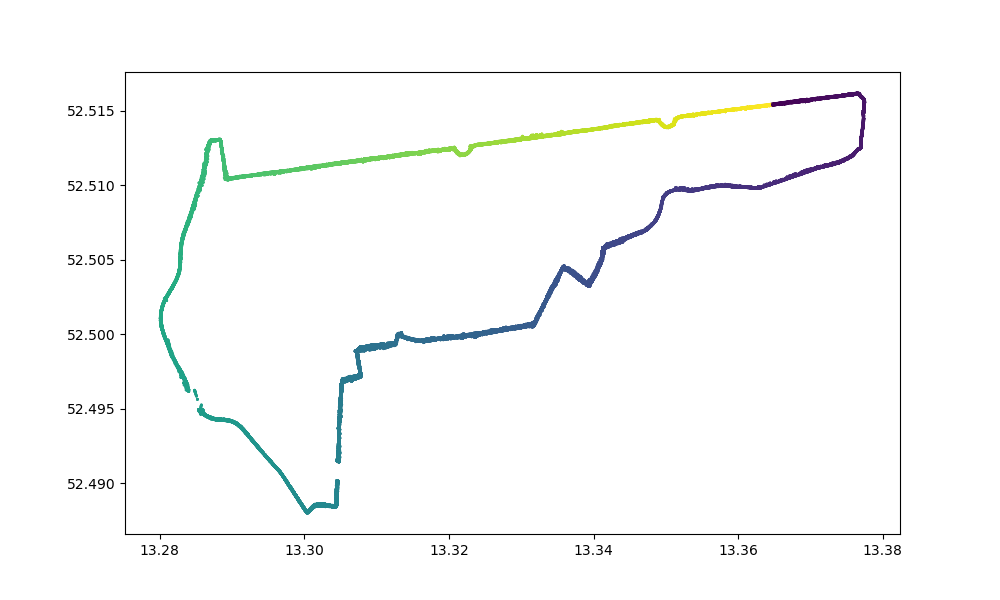

In [123]:
%matplotlib widget
#meas = 13
#pc = 1
#df = pd.read_parquet(f"data/meas-{meas:02d}/pc_{pc}-gps-{meas:02d}.parquet")
plt.scatter(df['Longitude'], df['Latitude'], 1, df['Pos in Ref Round'])

<AxesSubplot:xlabel='Pos in Ref Round', ylabel='datarate_mean'>

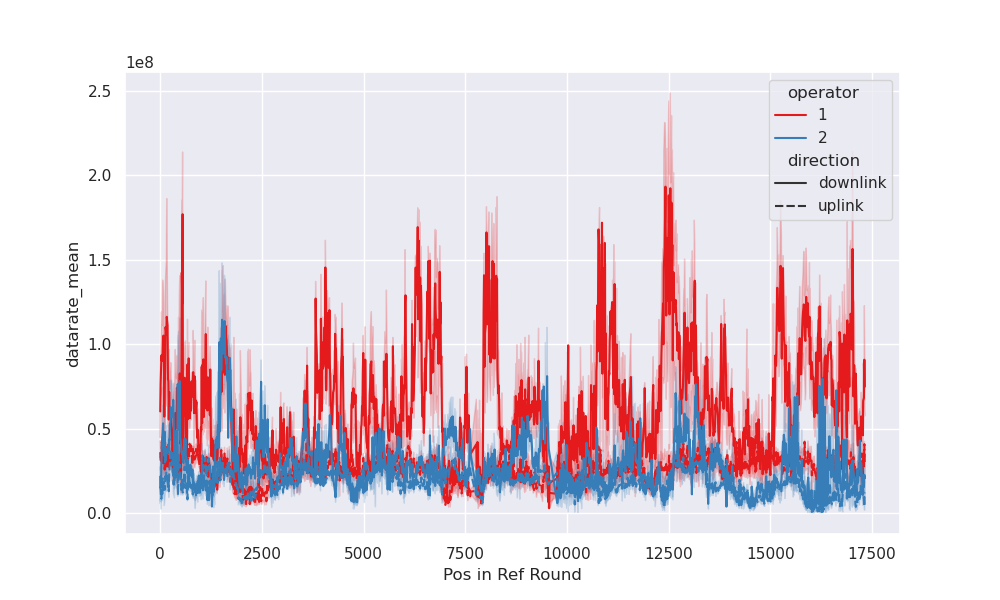

In [147]:
%matplotlib widget
df_plot = df.query("scenario == 'A3D' or scenario == 'A3U'").reset_index()
df_plot['Pos in Ref Round'] = df_plot['Pos in Ref Round'].round(-1)
sns.lineplot(data=df_plot, x='Pos in Ref Round', y='datarate_mean', hue='operator', style='direction', palette='Set1')

<AxesSubplot:xlabel='Pos in Ref Round', ylabel='datarate_mean'>

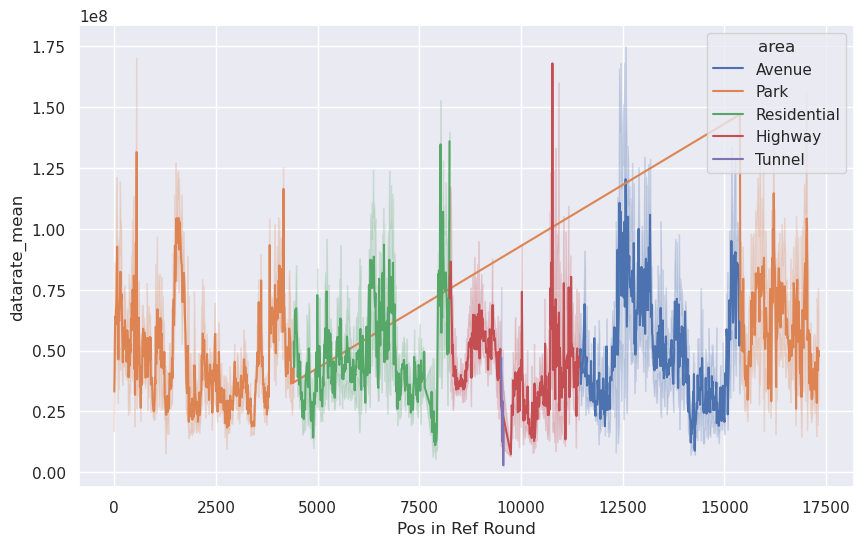

In [142]:
%matplotlib inline
df_plot = df.query("scenario == 'A3D'").reset_index()
df_plot['Pos in Ref Round'] = df_plot['Pos in Ref Round'].round(-1)
sns.lineplot(data=df_plot, x='Pos in Ref Round', y='datarate_mean', hue='area')